# **In this notebook we benchmark runtime of meK-Means on real data**

In [76]:
import h5py
import scanpy as sc
import anndata
import loompy as lp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import glob
import importlib
import random

In [2]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/') #OR pip install monod

In [3]:
import monod
importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, analysis, mminference

In [4]:
from timeit import default_timer as timer

**Download data and metadata for analysis**

In [ ]:
#Developing mouse brain data (19G)
!wget --content-disposition https://storage.googleapis.com/linnarsson-lab-loom/dev_all.loom

In [ ]:
#Gene length annotations
!wget --content-disposition https://raw.githubusercontent.com/pachterlab/CGP_2023/main/references/gg_200524_mouse_genome_polyA_cum_1

#Human reference (GRCh38-2020-A) for also available
!wget --content-disposition https://raw.githubusercontent.com/pachterlab/CGP_2023/main/references/gg_200525_genome_polyA_cum_3

In [ ]:
#Analyze previously saved results
!wget --content-disposition https://github.com/pachterlab/CGP_2023/raw/main/analysis_output/all_res_csvs.tar.gz
!tar -xvf all_res_csvs.tar.gz

## **Set up files for cell number meK-Means Runs**

In [10]:
#Data from http://mousebrain.org/development/downloads.html (dev_all.loom)

ds = lp.connect('./dev_all.loom')
print(ds.ca.keys())
print(len(ds.ca['CellID']))
print()
print(ds.ra.keys())
print(len(ds.ra['Gene']))
print(ds.ra['Gene'][0])
ds.close()

['Age', 'BTSNE', 'CellCycle', 'CellID', 'Cell_Conc', 'Chemistry', 'ChipID', 'Class', 'ClusterName', 'Clusters', 'Date_Captured', 'DonorID', 'DoubletFinderPCA', 'HPF', 'HPF_LogPP', 'HPF_theta', 'IsCycling', 'Label', 'Location_E9_E11', 'NCellsCluster', 'NGenes', 'Num_Pooled_Animals', 'PCA', 'PCR_Cycles', 'Plug_Date', 'Project', 'PseudoAge', 'PseudoTissue', 'Region', 'SampleID', 'SampleName', 'Sample_Index', 'Sex', 'Species', 'Split', 'Strain', 'Subclass', 'TSNE', 'Target_Num_Cells', 'Tissue', 'TotalUMI', 'Transcriptome', 'UMAP', 'UMAP3D', 'cDNA_Lib_Ok', 'ngperul_cDNA']
292495

['Accession', 'Chromosome', 'End', 'Gamma', 'Gene', 'HPF', 'HPF_beta', 'MultilevelMarkers', 'Selected', 'Start', 'Strand', 'Valid']
31053
Ptk6


Make a new loom with only genes that pass U/S threshold (with enough counts for modeling)

In [11]:
def nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02):
    '''
    Take in U,S matrices, and find genes that meet var/mean thresh
    U,S are cellxgene
    '''
    var_threshold = var_t
    U_mean = U.mean(0)
    S_mean = S.mean(0)
    U_var = U.var(0)
    S_var = S.var(0)

    #if l == '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01A02_raw.loom':
    u_min = u_min
    s_min =  s_min


    fitted_idx = (U_mean > u_min) & (S_mean > s_min) \
    & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
    & (((S_var-S_mean)/(S_mean**2)) > var_threshold)\
    & (np.abs(np.log(S_mean/U_mean)) < 4) 
    
    
    return fitted_idx

In [12]:
l = './dev_all.loom' #Download from online 

ds = lp.connect(l)
S = ds.layers['spliced'][:,:]
U = ds.layers['unspliced'][:,:]
bars = ds.ca['CellID']
g_names = ds.ra['Gene']
ds.close()

fitted_idx = nb_thresh(U.T,S.T,var_t = 1.5,u_min =0.02,s_min =0.02)
num_chosen = np.sum(fitted_idx)
print('No. all genes that pass thresh: ', num_chosen)

No. all genes that pass thresh:  3686


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


Filter for all genes with enough U/S counts

In [14]:
#Save loom, h5 files with genes that pass NB Thresh
S_sub = S[fitted_idx,:]
U_sub = U[fitted_idx,:]
g_names_sub = g_names[fitted_idx]
retAdata = anndata.AnnData(
    X=S_sub.T,
    layers={
        'spliced': S_sub.T,
        'unspliced': U_sub.T
    },
    obs=pd.DataFrame({'barcode': bars},
                     index=bars),
    var=pd.DataFrame({'gene_name': g_names_sub},index=g_names_sub)
)

retAdata.write_loom('./dev_gfilt.loom')

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  del sys.path[0]


In [15]:
new_l = './dev_gfilt.loom'

In [ ]:
# annots=pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1',delim_whitespace=True,header=None)
# print(annots.head())
# filt_markers = [m for m in g_names_sub if m in list(annots[0])]
# len(filt_markers)

In [117]:
#Define loom and transcriptome for each run

num_genes = [500]*4
num_cells = [100,1000,10000,100000]
cfs = [] #cell barcode filters

for n in num_cells:
    chosen_bars = random.sample(list(bars), n)
    cfs += [pd.Categorical(bars).isin(chosen_bars)]

gs_forfit = random.sample(list(g_names_sub), num_genes[0]) #Fit same genes for consistency

looms = [new_l]*4

transcrips = ['./gg_200524_mouse_genome_polyA_cum_1']*4

datas = ['dev_gfilt_'+str(i)+'_cells' for i in num_cells]
attribute_names =[('unspliced','spliced'),'gene_name','barcode']




## **Run cell number meK-Means Runs**

In [120]:
epochs = 5
K=10

**Get timing for full dataset runs**

In [57]:
# !rm -r /home/tchari/perturbCME/notebooks/fits/dev_all_0330

In [ ]:
!mkdir ./fits

In [121]:
times = []

dir_strings = []

data_strings = []

#!mkdir ./fits/dev_all_0330

!mkdir ./fits/dev_all_0401

result_strings = []

for loom,transc,data_name,n_gs,c_filt in zip(looms,transcrips,datas,num_genes,cfs):
    dir_string,dataset_string = monod.preprocess.construct_batch([loom], \
                                                 transc, \
                                                 [data_name], \
                                                 attribute_names=attribute_names,\
                                                 batch_location='./fits/dev_all_0401',\
                                                 meta=data_name,batch_id=1,\
                                                 n_genes=n_gs,viz=False,exp_filter_threshold=None,
                                                 cf=[c_filt],genes_to_fit=gs_forfit)
    dir_strings += [dir_string]
    data_strings += [dataset_string]
    
    #Define bounds for params
    phys_lb = [-2.0, -1.8, -1.8 ] 
    phys_ub = [4.2, 2.5, 2.5] 
    samp_lb = [-6.777777777777778, -0.6999999999999997] 
    samp_ub = [-6.777777777777778, -0.6999999999999997] 
    gridsize = [1,1] #Already have tech params


    # ---------------- meK-Means Inference ---------------- 
    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_string[0],fitmodel,k=K,epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(loom, transc, data_name,
                dataset_string[0], dir_string, viz=False, dataset_attr_names=attribute_names,cf=c_filt)

    #Run inference(fit_all_grid_points()) and Save result file strings
    start = timer()
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 
    end = timer()
    print((end - start)/3600,' hr')
    times += [(end - start)/3600]
    
    
    result_strings.append(full_result_string)
    

fin_results = pd.DataFrame()
fin_results['Cells'] = num_cells
fin_results['Time'] = times
fin_results

mkdir: cannot create directory ‘/home/tchari/perturbCME/notebooks/fits/dev_all_0330’: File exists


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.04s/it]


mstep self.weights:  [0.12142621 0.36274136 0.11000003 0.02511087 0.08153963 0.11944806
 0.03000001 0.04985732 0.01987654 0.07999997]
Q Function:  -48615.80138987009



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.97s/it]


mstep self.weights:  [1.03467409e-01 5.60782564e-01 9.93216500e-02 1.00000090e-02
 6.84309618e-02 9.20738738e-02 1.00000101e-02 3.00000070e-02
 1.73208216e-08 2.59234980e-02]
Q Function:  -47450.70082974353



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.72s/it]


mstep self.weights:  [1.00001009e-02 9.54899510e-01 9.99999936e-09 1.00001126e-08
 3.50928520e-02 1.02673597e-08 9.99999900e-09 7.47687934e-06
 9.99999900e-09 9.99999900e-09]
Q Function:  -39794.19768592616



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:26<00:00, 13.07s/it]


mstep self.weights:  [9.99999900e-09 9.89999911e-01 9.99999900e-09 9.99999900e-09
 1.00000090e-02 9.99999900e-09 9.99999900e-09 9.99999900e-09
 9.99999900e-09 9.99999900e-09]
Q Function:  -34376.479899703816



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.91s/it]


mstep self.weights:  [9.9999990e-09 9.9999991e-01 9.9999990e-09 9.9999990e-09 9.9999990e-09
 9.9999990e-09 9.9999990e-09 9.9999990e-09 9.9999990e-09 9.9999990e-09]
Q Function:  -35447.08322051086

0.06808687479907853  hr


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.74s/it]


mstep self.weights:  [0.01093684 0.11500976 0.02096748 0.0098205  0.01884543 0.04220578
 0.18172754 0.03901025 0.05175193 0.50972449]
Q Function:  -353633.044246653



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:26<00:00,  6.52s/it]


mstep self.weights:  [9.99999990e-10 2.19642318e-01 9.99999990e-10 9.99999990e-10
 1.00104320e-09 9.99999990e-10 1.56406722e-01 9.99999990e-10
 9.73191028e-03 6.14219044e-01]
Q Function:  -342717.7978877828



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.90s/it]


mstep self.weights:  [9.99999990e-10 2.91842221e-01 9.99999990e-10 9.99999990e-10
 9.99999990e-10 9.99999990e-10 1.13214313e-01 9.99999990e-10
 9.99999990e-10 5.94943460e-01]
Q Function:  -338285.1765887185



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:24<00:00,  8.17s/it]


mstep self.weights:  [9.99999990e-10 3.74124044e-01 9.99999990e-10 9.99999990e-10
 9.99999990e-10 9.99999990e-10 4.63446050e-02 9.99999990e-10
 9.99999990e-10 5.79531344e-01]
Q Function:  -338274.67969748686



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:25<00:00,  8.64s/it]


mstep self.weights:  [9.99999990e-10 4.13986056e-01 9.99999990e-10 9.99999990e-10
 9.99999990e-10 9.99999990e-10 6.99567344e-03 9.99999990e-10
 9.99999990e-10 5.79018264e-01]
Q Function:  -338074.7690576184

0.06616939909445743  hr


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.68s/it]


mstep self.weights:  [0.04220075 0.09698212 0.08261831 0.13108289 0.10452387 0.17871336
 0.1644199  0.07619675 0.06068968 0.06257237]
Q Function:  -3348182.98963507



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.74s/it]


mstep self.weights:  [0.03134342 0.08311503 0.09285648 0.15510902 0.0834973  0.15275994
 0.15419673 0.12355894 0.04246217 0.08110097]
Q Function:  -3219445.6453289413



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.18s/it]


mstep self.weights:  [2.26890645e-02 4.30681819e-03 1.00964768e-01 2.14899340e-01
 7.59478625e-02 1.35111599e-01 1.47863253e-01 1.93565765e-01
 1.05165747e-10 1.04651530e-01]
Q Function:  -3252308.9650850105



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:27<00:00,  3.38s/it]


mstep self.weights:  [2.13294647e-02 9.99999999e-11 1.28720650e-01 2.02136574e-01
 4.62441938e-02 1.30098111e-01 1.65824652e-01 2.01263704e-01
 9.99999999e-11 1.04382651e-01]
Q Function:  -3233121.859113389



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:27<00:00,  3.44s/it]


mstep self.weights:  [2.01373395e-02 9.99999999e-11 1.49036711e-01 1.78353702e-01
 5.17431582e-02 1.27844702e-01 1.67349263e-01 2.01666117e-01
 9.99999999e-11 1.03869008e-01]
Q Function:  -3226424.36906818

0.07512981440095852  hr


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.82s/it]


mstep self.weights:  [0.06725504 0.04684885 0.04957397 0.08674228 0.09763254 0.0930127
 0.0730242  0.11222563 0.18042794 0.19325684]
Q Function:  -32996613.496638957



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.76s/it]


mstep self.weights:  [0.10542459 0.05038914 0.0566359  0.09927312 0.0859016  0.09141851
 0.05948862 0.11139135 0.14962793 0.19044924]
Q Function:  -31594796.059128635



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.67s/it]


mstep self.weights:  [0.12486378 0.05081452 0.06197859 0.10702926 0.07425685 0.09011079
 0.05589143 0.11238471 0.13641271 0.18625735]
Q Function:  -31598404.67801789



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.63s/it]


mstep self.weights:  [0.13436212 0.0474106  0.06969016 0.1110202  0.07062376 0.08922226
 0.05328734 0.11445245 0.12834156 0.18158958]
Q Function:  -31568076.61794128



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.60s/it]


mstep self.weights:  [0.14535936 0.04128293 0.08067093 0.11410992 0.05512149 0.08859009
 0.05685215 0.11749363 0.12500985 0.17550965]
Q Function:  -31689793.315010488

0.15238198054902669  hr


,Cells,Time
0,100,0.068087
1,1000,0.066169
2,10000,0.075130
3,100000,0.152382


In [122]:
# fin_results.to_csv('dev_cell_timing_0401.csv',index=None)

In [123]:
fin_results = pd.read_csv('dev_cell_timing_0401.csv') #Read in from downloaded file
fin_results['Time'] = 60*fin_results['Time'] #convert to minutes

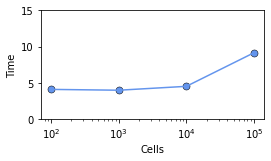

In [126]:
plt.figure(figsize=(4,2)) # Width and Height of the chart
sns.lineplot(x='Cells',
             y='Time',
             data=fin_results,
             marker=None,color='cornflowerblue')
sns.scatterplot(x='Cells',
             y='Time',
             data=fin_results,
               s=50,edgecolor='black',linewidth=0.5,
               color='cornflowerblue')
plt.ylim([0,15])
plt.xscale('log')

plt.savefig('dev_cells_timing.pdf')

In [ ]:
#Runtime does not change order of magnitude, even across three orders of magnitude change in number of cells

In [129]:
#Check to make sure diff no. of cells were fit
# test = '/home/tchari/perturbCME/notebooks/fits/dev_all_0401/gg_240330_025_dev_gfilt_1000_cells_1/dev_gfilt_1000_cells'
# sd  = monod.analysis.load_search_data(test+'/raw.sd')
# sd.layers[1].shape

(500, 1000)

## **Set up files for gene number meK-Means Runs**

In [130]:
#Define loom and transcriptome for each run

num_genes = [100,500,1000,2000]
num_cells = [10000]*4

chosen_bars = random.sample(list(bars), num_cells[0]) #do the same cells for consistency
cfs = [pd.Categorical(bars).isin(chosen_bars)]*4
    


looms = [new_l]*4

transcrips = ['./gg_200524_mouse_genome_polyA_cum_1']*4

datas = ['dev_gfilt_'+str(i)+'_genes' for i in num_genes]
attribute_names =[('unspliced','spliced'),'gene_name','barcode']







## **Run cell number meK-Means Runs**

In [131]:
epochs = 1
K=10

**Get timing for full dataset runs**

In [132]:
times = []

dir_strings = []

data_strings = []


result_strings = []

for loom,transc,data_name,n_gs,c_filt in zip(looms,transcrips,datas,num_genes,cfs):
    dir_string,dataset_string = monod.preprocess.construct_batch([loom], \
                                                 transc, \
                                                 [data_name], \
                                                 attribute_names=attribute_names,\
                                                 batch_location='./fits/dev_all_0401',\
                                                 meta=data_name,batch_id=1,\
                                                 n_genes=n_gs,viz=False,cf=[c_filt])
    dir_strings += [dir_string]
    data_strings += [dataset_string]
    
    #Define bounds for params
    phys_lb = [-2.0, -1.8, -1.8 ] 
    phys_ub = [4.2, 2.5, 2.5] 
    samp_lb = [-6.777777777777778, -0.6999999999999997] 
    samp_ub = [-6.777777777777778, -0.6999999999999997] 
    gridsize = [1,1] #Already have tech params


    # ---------------- meK-Means Inference ---------------- 
    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_string[0],fitmodel,k=K,epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(loom, transc, data_name,
                dataset_string[0], dir_string, viz=False, dataset_attr_names=attribute_names,cf=c_filt)

    #Run inference(fit_all_grid_points()) and Save result file strings
    start = timer()
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 
    end = timer()
    print((end - start)/3600,' hr')
    times += [(end - start)/3600]
    
    
    result_strings.append(full_result_string)
    

fin_results = pd.DataFrame()
fin_results['Genes'] = num_genes
fin_results['Time'] = times
fin_results

/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.41it/s]


mstep self.weights:  [0.07648008 0.09177742 0.11370348 0.07066117 0.12607216 0.15566702
 0.13637707 0.05882533 0.09842515 0.07201113]
Q Function:  -700746.7547710893

0.008531439803644188  hr


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.78s/it]


mstep self.weights:  [0.16427314 0.06117756 0.09049696 0.04317409 0.16507511 0.2273025
 0.04928182 0.03352935 0.09120216 0.07448731]
Q Function:  -3527251.19094188

0.024085199505401153  hr


/home/tchari/monod/src/monod/mminference.py:513: RuntimeWarning: divide by zero encountered in true_divide
  divids = (1e4/tots)[:,None]
/home/tchari/monod/src/monod/mminference.py:514: RuntimeWarning: invalid value encountered in multiply
  S_t = S_t*divids
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.01s/it]


mstep self.weights:  [0.171101   0.05683375 0.06492224 0.08402313 0.05243117 0.16507304
 0.01101301 0.08217591 0.18184389 0.13058285]
Q Function:  -7287527.061893042

0.06222039240826335  hr


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:17<00:00, 31.72s/it]


mstep self.weights:  [0.08499319 0.16731881 0.1014316  0.09577507 0.05731988 0.05849658
 0.03590231 0.05315783 0.1811647  0.16444004]
Q Function:  -14487734.339399692

0.19535785528520744  hr


,Genes,Time
0,100,0.008531
1,500,0.024085
2,1000,0.062220
3,2000,0.195358


In [133]:
# fin_results.to_csv('dev_genes_timing_0401.csv',index=None)

In [134]:
fin_results = pd.read_csv('dev_genes_timing_0401.csv') #Read in from downloaded file
fin_results['Time'] = 60*fin_results['Time'] #convert to minutes

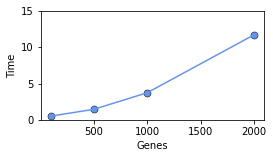

In [137]:
plt.figure(figsize=(4,2)) # Width and Height of the chart
sns.lineplot(x='Genes',
             y='Time',
             data=fin_results,
             marker=None,color='cornflowerblue')
sns.scatterplot(x='Genes',
             y='Time',
             data=fin_results,
               s=50,edgecolor='black',linewidth=0.5,
               color='cornflowerblue')
plt.ylim([0,15])
plt.savefig('dev_genes_timing.pdf')